In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# 1) Load data
DATA_PATH = "/Users/liiiii/Desktop/project b/wk3/EVAT-Data-Science/Use_Cases/Cost Comparison Tool/Datasets/dummy_data.csv"
df = pd.read_csv(DATA_PATH)
df.head()

,selected_ev,distance_km,electricity_price_per_kwh,ice_eff_l_per_100km,petrol_price_per_l,ev_trip_cost,ice_trip_cost,savings_ice_minus_ev,ev_co2_kg,ice_co2_kg,co2_saved_kg,state_elec,state_petrol,notes
0,MG MG4 64kWh EV 4WD,100.0,0.342,50.00,1.88,5.13,94.00,88.87,10.50,115.50,105.00,SA,TAS,ICE fetch failed; manual entry path simulated
1,Audi Q8 Q8 e-tron quattro,250.0,0.070,9.79,0.01,2.63,0.24,-2.38,26.25,56.54,30.29,NT,ACT,NaN
2,Peugeot 2008 e2008 GT,400.0,0.070,50.00,1.89,4.20,378.00,373.80,42.00,462.00,420.00,ACT,NT,ICE fetch failed; manual entry path simulated
3,Volvo C40 Recharge Twin,500.0,0.399,6.63,1.89,29.93,62.65,32.73,52.50,76.58,24.08,WA,VIC,ICE fetch failed; manual entry path simulated
4,Tesla Model 3 Long Range H5LDB,100.0,0.320,7.75,189.74,4.80,1470.49,1465.69,10.50,17.90,7.40,NSW,NSW,NaN


In [2]:
# 2) Basic sanity / outlier handling

# Clip impossible/obvious mistakes:
df["petrol_price_per_l"] = df["petrol_price_per_l"].clip(0, 5.0)
df["electricity_price_per_kwh"] = df["electricity_price_per_kwh"].clip(0, 2.0)
df["distance_km"] = df["distance_km"].clip(lower=0, upper=df["distance_km"].quantile(0.99))
df["ice_eff_l_per_100km"] = df["ice_eff_l_per_100km"].clip(lower=0)


y_raw = df["savings_ice_minus_ev"].copy()
q_low, q_high = y_raw.quantile([0.01, 0.99])
y = y_raw.clip(q_low, q_high)

# 3) Feature engineering
# -----------------------------
# Assumption: average EV consumption ~ 0.15 kWh/km 

EV_KWH_PER_KM = 0.15
df["fuel_cost_per_km"] = (df["ice_eff_l_per_100km"] / 100.0) * df["petrol_price_per_l"]
df["ev_cost_per_km"] = df["electricity_price_per_kwh"] * EV_KWH_PER_KM
df["distance_x_petrol"] = df["distance_km"] * df["petrol_price_per_l"]
df["distance_x_elec"] = df["distance_km"] * df["electricity_price_per_kwh"]
df["eff_ratio"] = df["ice_eff_l_per_100km"] / (EV_KWH_PER_KM * 100)

base_features = [
    "distance_km",
    "electricity_price_per_kwh",
    "ice_eff_l_per_100km",
    "petrol_price_per_l",
    "fuel_cost_per_km",
    "ev_cost_per_km",
    "distance_x_petrol",
    "distance_x_elec",
    "eff_ratio",
]
X = df[base_features].copy()
X.head()

,distance_km,electricity_price_per_kwh,ice_eff_l_per_100km,petrol_price_per_l,fuel_cost_per_km,ev_cost_per_km,distance_x_petrol,distance_x_elec,eff_ratio
0,100.0,0.342,50.00,1.88,0.940000,0.05130,188.0,34.2,3.333333
1,250.0,0.070,9.79,0.01,0.000979,0.01050,2.5,17.5,0.652667
2,400.0,0.070,50.00,1.89,0.945000,0.01050,756.0,28.0,3.333333
3,500.0,0.399,6.63,1.89,0.125307,0.05985,945.0,199.5,0.442000
4,100.0,0.320,7.75,5.00,0.387500,0.04800,500.0,32.0,0.516667


In [3]:
# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
# 5) Modeling pipelines
numeric_transformer = Pipeline([("scaler", StandardScaler())])
preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, base_features)],
    remainder="drop",
)

models = {
    "LinearRegression": Pipeline([
        ("preprocess", preprocess),
        ("reg", LinearRegression())
    ]),
    "Ridge(alpha=1.0)": Pipeline([
        ("preprocess", preprocess),
        ("reg", Ridge(alpha=1.0, random_state=42))
    ]),
    "Poly2 + Ridge": Pipeline([
        ("poly_prep", ColumnTransformer([
            ("poly", Pipeline([
                ("poly", PolynomialFeatures(degree=2, include_bias=False)),
                ("scaler", StandardScaler())
            ]), base_features)
        ])),
        ("reg", Ridge(alpha=1.0, random_state=42))
    ]),
    "RandomForest": Pipeline([
        ("preprocess", "passthrough"),
        ("reg", RandomForestRegressor(
            n_estimators=400,
            max_depth=None,
            min_samples_leaf=2,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "GradientBoosting": Pipeline([
        ("preprocess", "passthrough"),
        ("reg", GradientBoostingRegressor(
            learning_rate=0.05,
            n_estimators=350,
            max_depth=3,
            subsample=0.9,
            random_state=42
        ))
    ]),
}

In [4]:
def evaluate(y_true, y_pred, label):
    return {
        "Model": label,
        "R2": r2_score(y_true, y_pred),
        "RMSE": mean_squared_error(y_true, y_pred, squared=False),
        "MAE": mean_absolute_error(y_true, y_pred),
    }

results = []
trained = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results.append(evaluate(y_test, y_pred, name))
    trained[name] = pipe

score_df = pd.DataFrame(results).sort_values("R2", ascending=False)
score_df

TypeError: got an unexpected keyword argument 'squared'

In [10]:
  import sklearn
  print(sklearn.__version__)
  import sys
  print(sys.executable)

1.7.2
/opt/anaconda3/envs/cost-env/bin/python


In [12]:
import inspect; print(inspect.signature(mean_squared_error))

(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')


In [14]:
# 6) Train, evaluate, compare
def evaluate(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)  
    rmse = np.sqrt(mse)
    return {
        "Model": label,
        "R2": r2_score(y_true, y_pred),
        "RMSE": rmse,
        "MAE": mean_absolute_error(y_true, y_pred),
    }

results = []
trained = {}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results.append(evaluate(y_test, y_pred, name))
    trained[name] = pipe

score_df = pd.DataFrame(results).sort_values("R2", ascending=False)
score_df

,Model,R2,RMSE,MAE
4,GradientBoosting,0.968968,9371.385561,1383.060508
3,RandomForest,0.967771,9550.401819,1274.930564
2,Poly2 + Ridge,0.946147,12345.330713,2704.460390
1,Ridge(alpha=1.0),0.836252,21527.069459,6340.590631
0,LinearRegression,0.836236,21528.132742,6341.028145



Best model: GradientBoosting


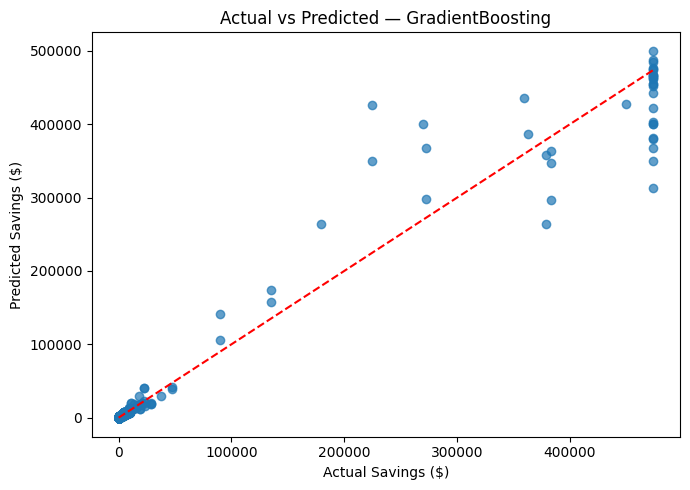

In [16]:
# 7) Best model diagnostics
# -----------------------------
best_name = score_df.iloc[0]["Model"]
best_model = trained[best_name]
print(f"\nBest model: {best_name}")

# Parity plot for the best model
y_pred_best = best_model.predict(X_test)
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred_best, alpha=0.7)
mn, mx = y_test.min(), y_test.max()
plt.plot([mn, mx], [mn, mx], "r--")
plt.xlabel("Actual Savings ($)")
plt.ylabel("Predicted Savings ($)")
plt.title(f"Actual vs Predicted — {best_name}")
plt.tight_layout()
plt.show()

In [18]:
# 8) Simple scenario forecasting helper
# -----------------------------
def forecast_savings(
    distance_km,
    electricity_price_per_kwh,
    ice_eff_l_per_100km,
    petrol_price_per_l,
    model=best_model
):
    row = pd.DataFrame([{
        "distance_km": distance_km,
        "electricity_price_per_kwh": electricity_price_per_kwh,
        "ice_eff_l_per_100km": ice_eff_l_per_100km,
        "petrol_price_per_l": petrol_price_per_l,
        "fuel_cost_per_km": (ice_eff_l_per_100km / 100.0) * petrol_price_per_l,
        "ev_cost_per_km": electricity_price_per_kwh * EV_KWH_PER_KM,
        "distance_x_petrol": distance_km * petrol_price_per_l,
        "distance_x_elec": distance_km * electricity_price_per_kwh,
        "eff_ratio": ice_eff_l_per_100km / (EV_KWH_PER_KM * 100),
    }])
    return float(model.predict(row)[0])

# Example forecast (tweak as needed)
example = forecast_savings(
    distance_km=250,
    electricity_price_per_kwh=0.30,
    ice_eff_l_per_100km=7.5,
    petrol_price_per_l=2.10
)
print(f"\nExample scenario forecasted savings: ${example:,.2f}")


Example scenario forecasted savings: $18.25
